In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
sns.set(font_scale=1.3, style='ticks')


In [2]:
#Specify number of replicates (crosses) and model/results folders

num_crosses = 4
train_dir = '/home/jlinder/borzoi_sc/borzoi/examples/saved_models'

#Padding for drawing text annotations within plots
eps = 0.05


In [3]:
#Read target descriptions

fold3_acc_file = '%s/f3c0/testg_rna3_no_unc-0/acc.txt' % (train_dir)
fold3_acc_df = pd.read_csv(fold3_acc_file, sep='\t', index_col=0).reset_index(drop=True)

#Get experimental assay types
descriptions = fold3_acc_df.description
experiments = pd.Series([desc.split(':')[0] for desc in descriptions])
experiments.value_counts()


RNA3    851
dtype: int64

In [4]:
#Get a mask of RNA-only targets
rna_mask = (experiments=='RNA3')


In [5]:
#Read test set accuracies

cross_pearsonr = []
cross_npearsonr = []

#Load per-cross performance (replicates)
for ci in range(num_crosses):
    cross_acc_file = '%s/f3c%d/testg_rna3_no_unc-0/acc.txt' % (train_dir, ci)
    cross_acc_df = pd.read_csv(cross_acc_file, sep='\t', index_col=0)
    
    #Store gene-level Pearson correlation
    cross_pearsonr.append(cross_acc_df.pearsonr)
    
    #Store mean-subtracted, quantile-normalized Pearson correlation
    cross_npearsonr.append(cross_acc_df.pearsonr_norm)

#Load ensemble performance (store as last cross)
cross_acc_file = '%s/f3c0/testg_rna3_no_unc-0/acc_ens.txt' % train_dir
cross_acc_df = pd.read_csv(cross_acc_file, sep='\t', index_col=0)
cross_pearsonr.append(cross_acc_df.pearsonr)
cross_npearsonr.append(cross_acc_df.pearsonr_norm)

cross_pearsonr = np.array(cross_pearsonr)
cross_npearsonr = np.array(cross_npearsonr)

#Average across replicates
mean_pearsonr = cross_pearsonr[:-1, :].mean(axis=0)
mean_npearsonr = cross_npearsonr[:-1, :].mean(axis=0)

#Get ensemble performance
ens_pearsonr = cross_pearsonr[-1:, :].mean(axis=0)
ens_npearsonr = cross_npearsonr[-1:, :].mean(axis=0)


In [6]:
#Print per-replicate performance (last entry is ensemble)
cross_pearsonr.mean(axis=1)


array([0.82682009, 0.82752623, 0.8282647 , 0.83186852, 0.83820865])

In [7]:
#Print per-replicate specificity performance (last entry is ensemble)
cross_npearsonr.mean(axis=1)


array([0.5988436 , 0.59188479, 0.59900379, 0.59996096, 0.61979175])

## RNA3

In [14]:
#Load list of coverage mean values for scRNA-seq experiments

cov_means = []
for _, row in cross_acc_df.iterrows() :
    mean_file = ''
    if 'tabula' in row['identifier'] :
        mean_file = '/home/drk/tillage/datasets/human/rna3/czi/' + row['identifier'][:-1] + '/covqc/means.txt'
    if 'linnar' in row['identifier'] :
        mean_file = '/home/drk/tillage/datasets/human/rna3/biccn/' + row['identifier'][:-1] + '/covqc/means.txt'
    
    with open(mean_file, 'rt') as f :
        mean_val = float(f.readline().strip().split('\t')[2])
        cov_means.append(mean_val)

cov_mean = np.array(cov_means, dtype='float32')


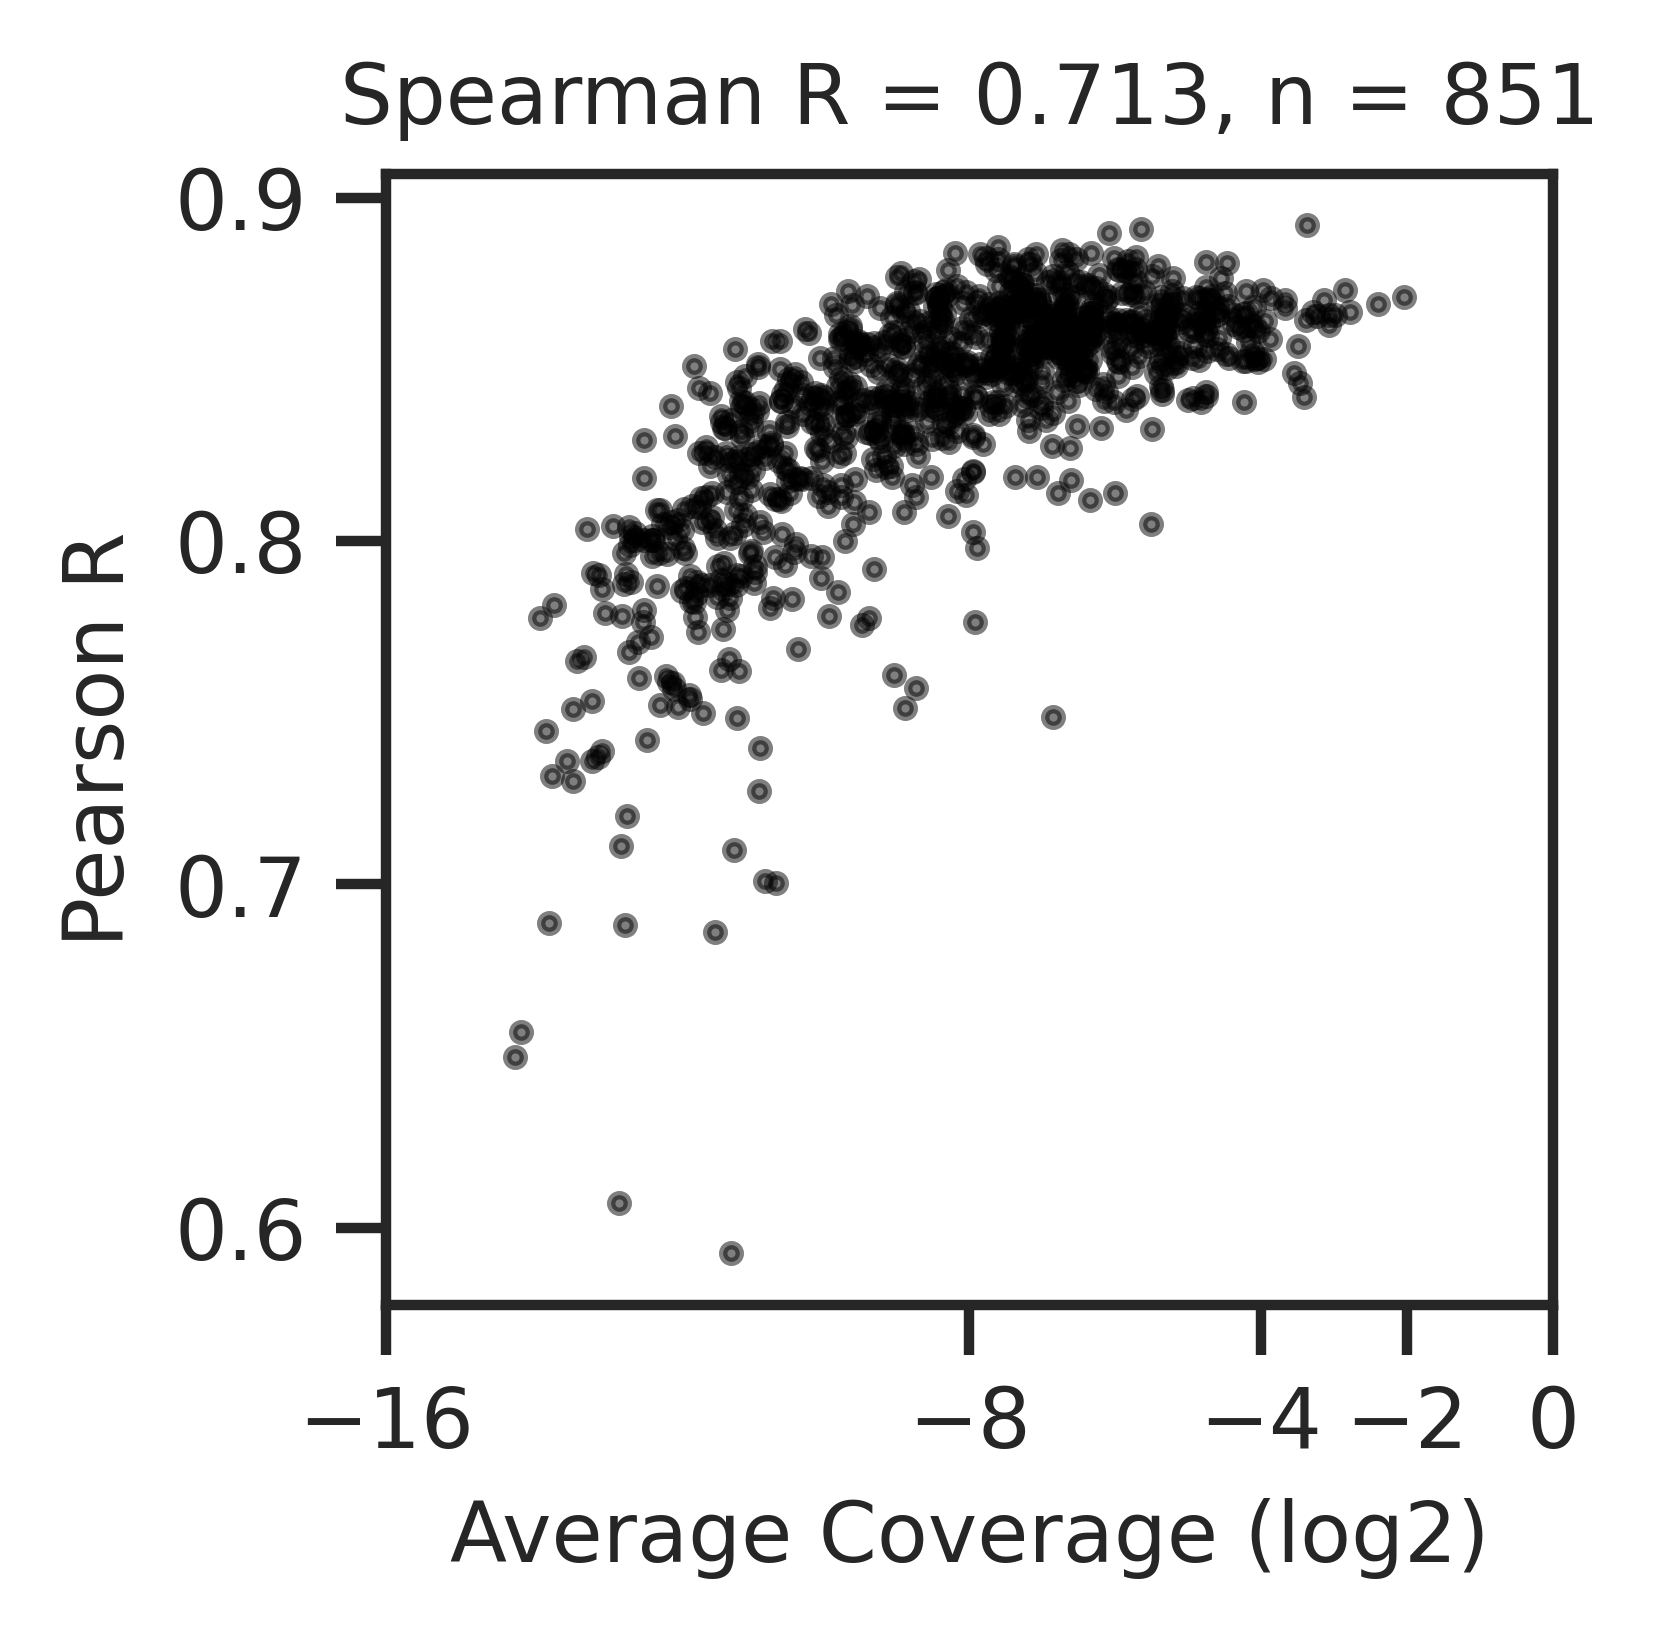

In [37]:
#Plot average depth vs correlation
from scipy.stats import spearmanr

keep_index = np.nonzero((ens_pearsonr[rna_mask] >= 0.) & (ens_pearsonr[rna_mask] <= 1.))[0]

r_val = spearmanr(np.log2(cov_mean[rna_mask][keep_index]), ens_pearsonr[rna_mask][keep_index])[0]

f = plt.figure(figsize=(3, 3), dpi=600)

plt.scatter(np.log2(cov_mean[rna_mask][keep_index]), ens_pearsonr[rna_mask][keep_index], c='black', s=4, alpha=0.5, rasterized=True)

plt.xticks([-16, -8, -4, -2, 0], fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel('Average Coverage (log2)', fontsize=10)
plt.ylabel('Pearson R', fontsize=10)

plt.title('Spearman R = ' + str(round(r_val, 3)) + ', n = ' + str(cov_mean[rna_mask][keep_index].shape[0]), fontsize=10)

plt.tight_layout()

plt.savefig('genes3_vs_depth_ens.pdf')

plt.show()


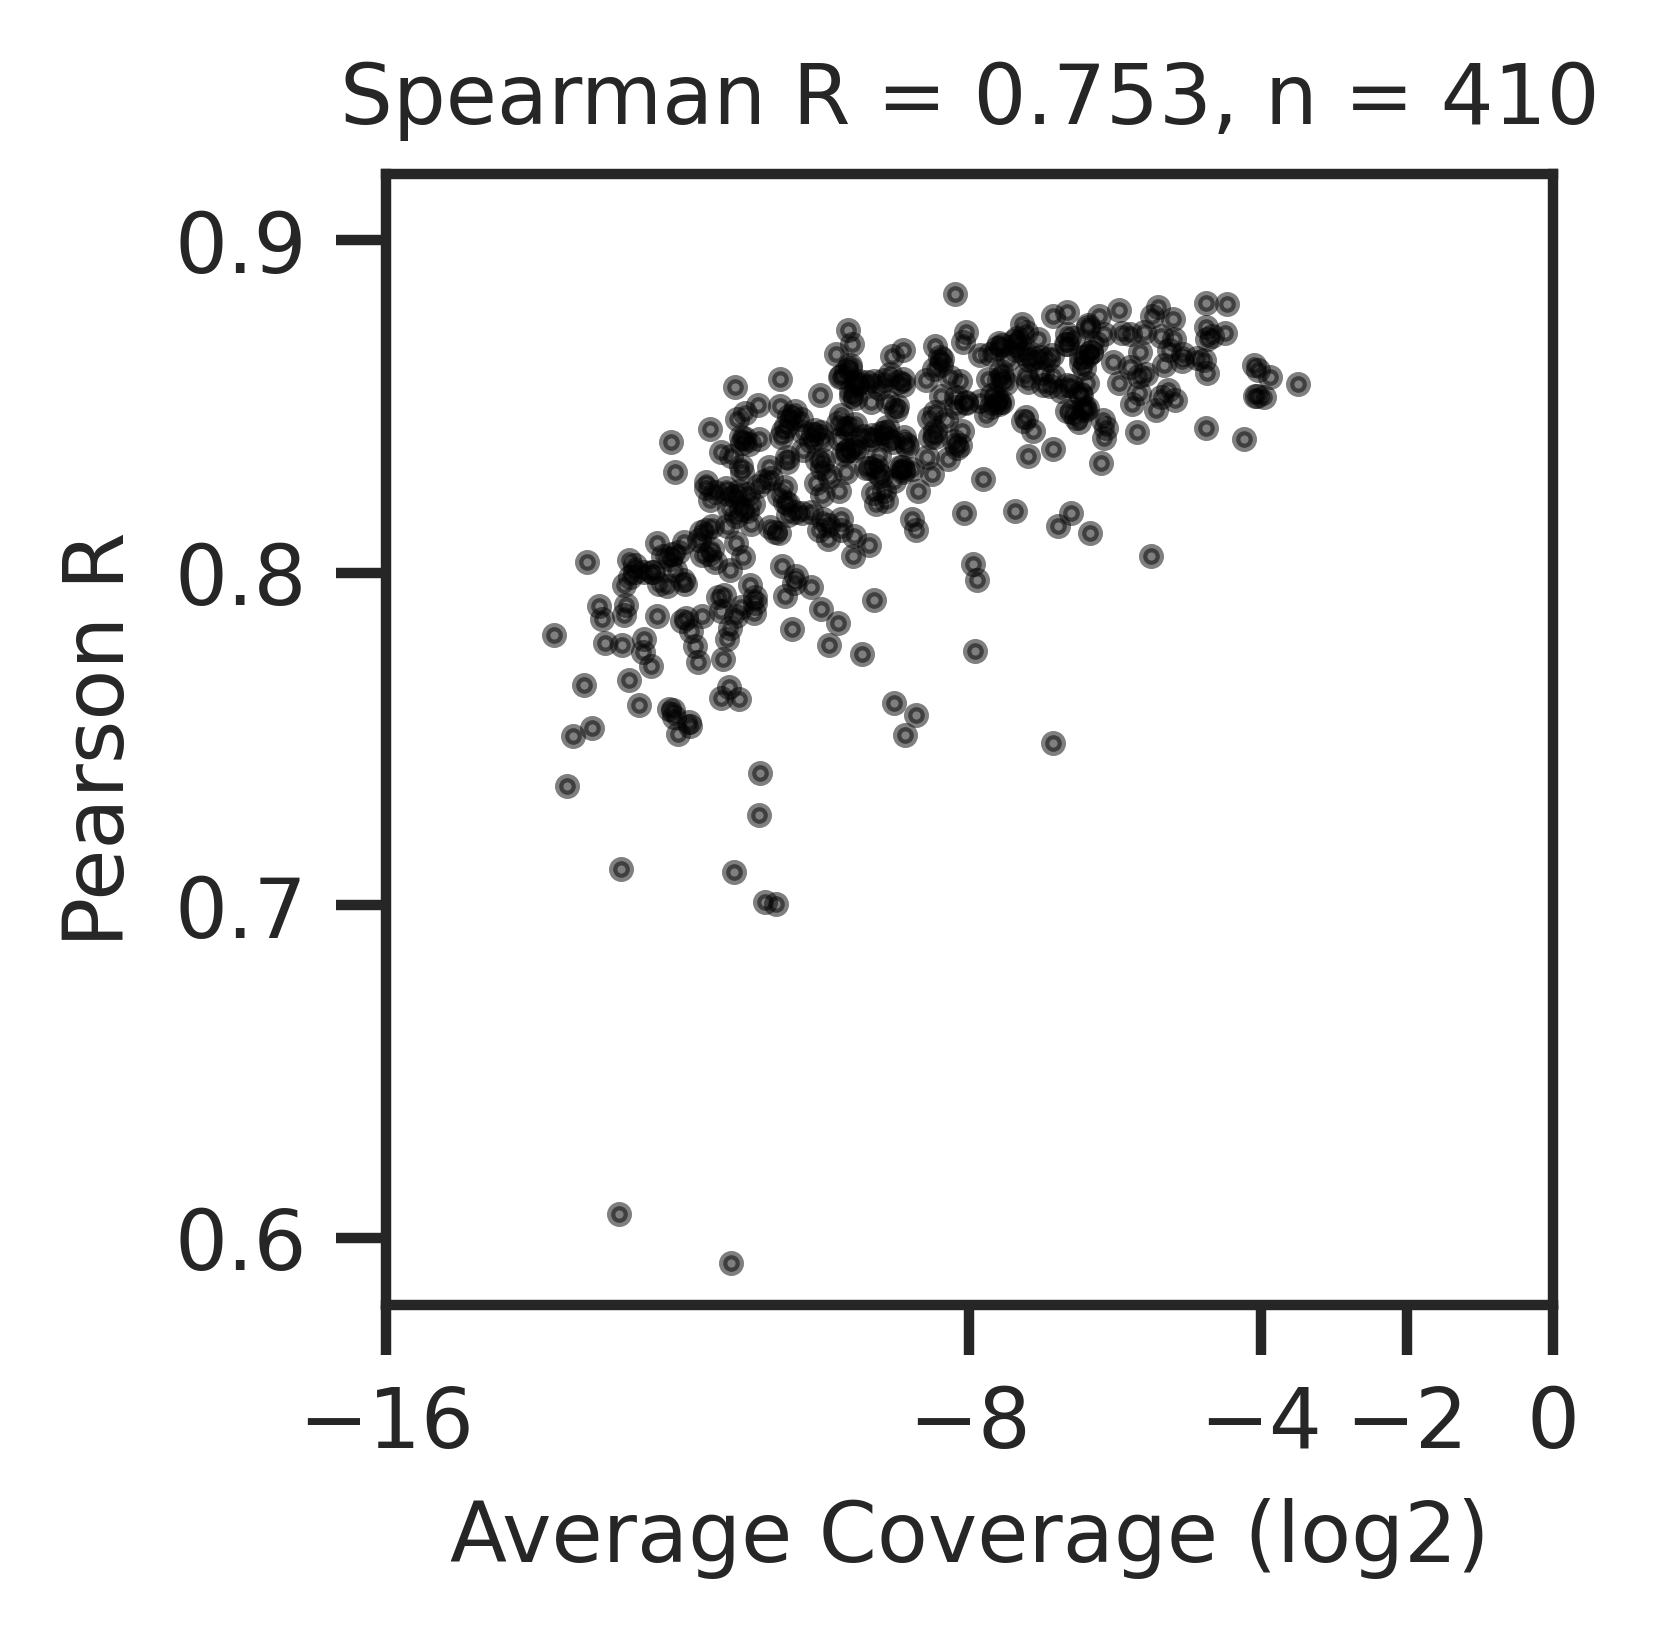

In [17]:
#Plot average depth vs correlation (tabula)
from scipy.stats import spearmanr

sub_mask = cross_acc_df['identifier'].str.contains('tabula').values

keep_index = np.nonzero((ens_pearsonr[rna_mask][sub_mask] >= 0.) & (ens_pearsonr[rna_mask][sub_mask] <= 1.))[0]

r_val = spearmanr(np.log2(cov_mean[rna_mask][sub_mask][keep_index]), ens_pearsonr[rna_mask][sub_mask][keep_index])[0]

f = plt.figure(figsize=(3, 3), dpi=600)

plt.scatter(np.log2(cov_mean[rna_mask][sub_mask][keep_index]), ens_pearsonr[rna_mask][sub_mask][keep_index], c='black', s=4, alpha=0.5, rasterized=True)

plt.xticks([-16, -8, -4, -2, 0], fontsize=10)
plt.yticks([0.6, 0.7, 0.8, 0.9], fontsize=10)

plt.xlabel('Average Coverage (log2)', fontsize=10)
plt.ylabel('Pearson R', fontsize=10)

plt.title('Spearman R = ' + str(round(r_val, 3)) + ', n = ' + str(cov_mean[rna_mask][sub_mask][keep_index].shape[0]), fontsize=10)

plt.ylim(0.58, 0.92)

plt.tight_layout()

plt.savefig('genes3_vs_depth_ens_tabula.pdf')

plt.show()


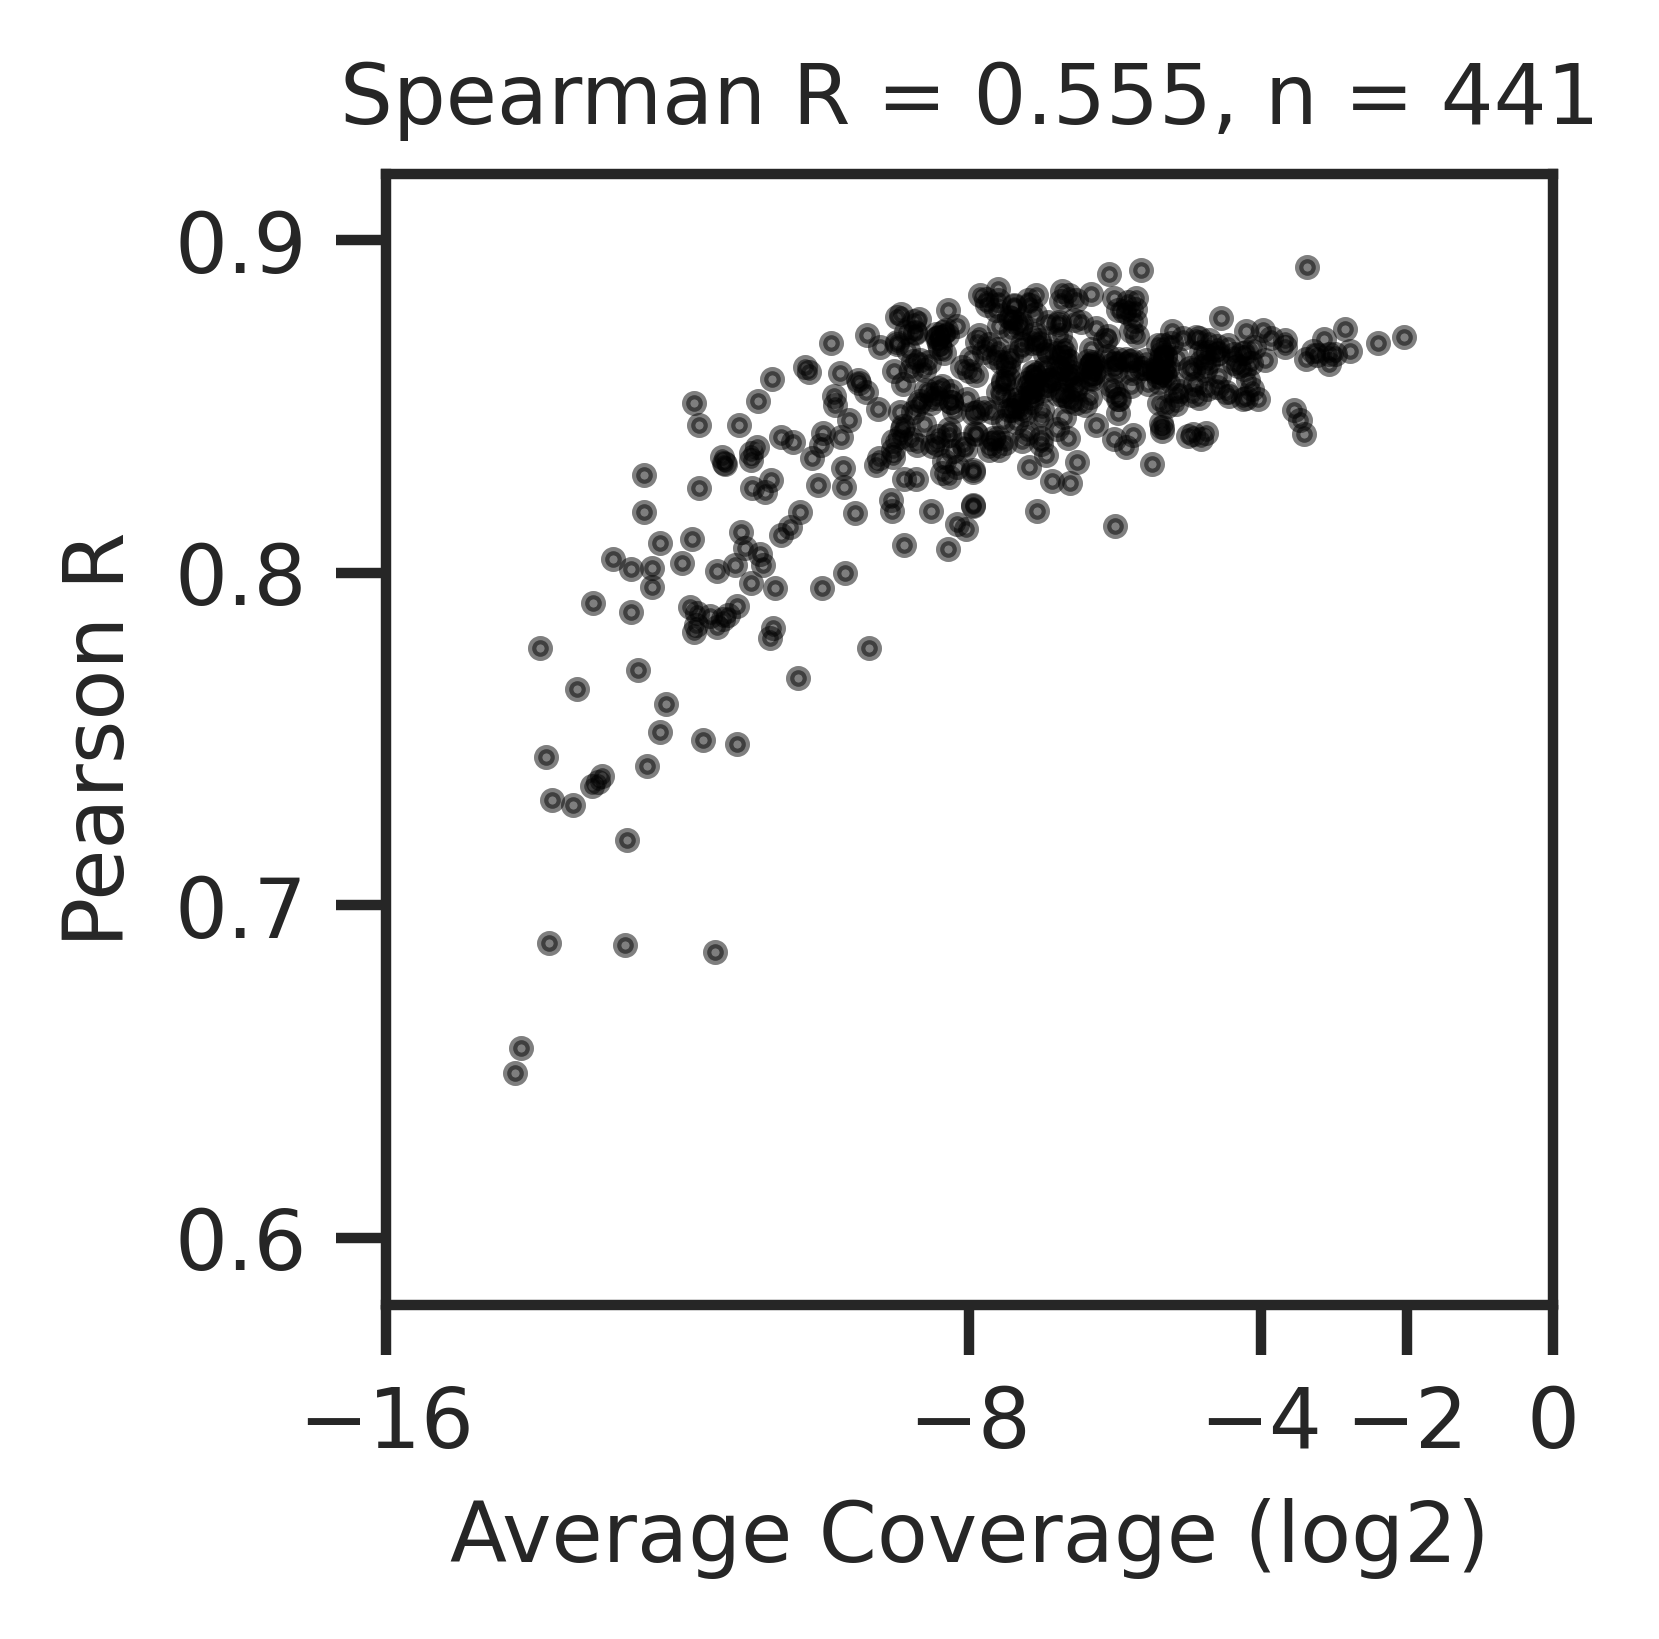

In [18]:
#Plot average depth vs correlation (linnar)
from scipy.stats import spearmanr

sub_mask = cross_acc_df['identifier'].str.contains('linnar').values

keep_index = np.nonzero((ens_pearsonr[rna_mask][sub_mask] >= 0.) & (ens_pearsonr[rna_mask][sub_mask] <= 1.))[0]

r_val = spearmanr(np.log2(cov_mean[rna_mask][sub_mask][keep_index]), ens_pearsonr[rna_mask][sub_mask][keep_index])[0]

f = plt.figure(figsize=(3, 3), dpi=600)

plt.scatter(np.log2(cov_mean[rna_mask][sub_mask][keep_index]), ens_pearsonr[rna_mask][sub_mask][keep_index], c='black', s=4, alpha=0.5, rasterized=True)

plt.xticks([-16, -8, -4, -2, 0], fontsize=10)
plt.yticks([0.6, 0.7, 0.8, 0.9], fontsize=10)

plt.xlabel('Average Coverage (log2)', fontsize=10)
plt.ylabel('Pearson R', fontsize=10)

plt.title('Spearman R = ' + str(round(r_val, 3)) + ', n = ' + str(cov_mean[rna_mask][sub_mask][keep_index].shape[0]), fontsize=10)

plt.ylim(0.58, 0.92)

plt.tight_layout()

plt.savefig('genes3_vs_depth_ens_linnar.pdf')

plt.show()
